This is a jupyter notebook where we discover and try to delete outliers for EEG.

In [561]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load libraries

In [562]:
%autoreload

# load libraries
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings
from sklearn.tree import export_graphviz
import graphviz

In [563]:
# read the dataset
dataset = pd.read_csv('../../dataset/dataset.csv')

# define features and target variables
# X = dataset.filter(regex=r'V\d+')             # take just EEG columns
X = dataset.drop(columns=['score', 'tempMean', 'tempSD'])        
# X = dataset.drop(columns=['score'])
y = dataset['score']


In [564]:
# check dataframes' shape
print(dataset.shape)
print(X.shape)
print(y.shape)

# check columns of X
print(X.columns)

(192, 90)
(192, 87)
(192,)
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41',
       'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51',
       'numFix', 'numSac', 'ratioFixSac', 'meanPupil', 'sdPupil', 'meanFixDur',
       'sdFixDur', 'meanSacVel', 'sdSacVel', 'meanSacAmp', 'sdSacAmp',
       'scanpathVel', 'infoProcess', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'bvpMean',
       'bvpSD', 'edaMean', 'edaSD', 'hrMean', 'hrSD'],
      dtype='object')


In [565]:
# Split the dataset into training and testing part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Feature engineering

In [566]:
def divideDataFrame(df: pd.DataFrame, regex_pattern: str) -> (pd.DataFrame, pd.DataFrame):
    df_matching = df.filter(regex=regex_pattern)
    df_not_matching = df.loc[:, ~df.columns.isin(df_matching.columns)]
    return df_matching, df_not_matching

def findOutliersUsingIQR(X: pd.DataFrame, bounds: float) -> pd.DataFrame:
    # find outliers using Interquartile range (IQR)
    outliers = pd.DataFrame(columns=X.columns)      # initialize an empty dataframe
    # EEG_columns = dataset.filter(regex=r'V\d+')             # take just EEG columns
    for target_variable in X:
        Q1 = X[target_variable].quantile(0.25)
        Q3 = X[target_variable].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - bounds * IQR
        upper_bound = Q3 + bounds * IQR

        # Identify outliers
        new_outliers = X[(X[target_variable] < lower_bound) | (X[target_variable] > upper_bound)]
        outliers = pd.concat([outliers, new_outliers]).drop_duplicates()
    return outliers


def removeOutliers(X: pd.DataFrame, y: pd.DataFrame, outliers: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    return X.drop(outliers.index), y.drop(outliers.index)


def normalizeData(X: pd.DataFrame) -> pd.DataFrame:
    # normalize data
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized
    

def reduceEEG(X: pd.DataFrame, concat_wavelengths: bool) -> pd.DataFrame:
    if concat_wavelengths:
        # concatenate wave lengths
        column_names = [[] for _ in range(3)]
        for i in range(51):
            column_names[i%3].append(f"V{i+1}")
    else:    
        # concatenate places
        column_names = [[] for _ in range(17)]
        for i in range(51):
            column_names[i//3].append(f"V{i+1}")

    X_EEG, X_not_EEG = divideDataFrame(X, regex_pattern=r'V\d+')
    column_groups = [X_EEG[names] for names in column_names]
    # means = [group.mean(axis=1) for group in column_groups]
    # X_reduction_EEG = pd.DataFrame({f'EEG_mean{i+1}': means[i] for i in range(len(column_groups))})
    
    ## Using PCA for dimensions reduction.
    new_dimensions = []
    for column_group in column_groups:
        pca = PCA()
        pca.fit(column_group)
        n_axes = 1
        pca.n_components = n_axes
        reduced_column = pca.transform(column_group)[:, 0]
        
        new_dimensions.append(reduced_column)
    new_dimensions = np.array(new_dimensions).T
        
    X_reduction_EEG = pd.DataFrame({f'EEG_reduced{i+1}' : new_dimensions[:, i] for i in range(len(column_groups))})
    X_result = pd.concat([X_reduction_EEG.reset_index(drop=True), X_not_EEG.reset_index(drop=True)], axis=1)

    return X_result


def transformFacialVideo(X: pd.DataFrame) -> pd.DataFrame:
    # feature engineering: convert facial expressions to emotions (according to 
    # https://imotions.com/blog/learning/research-fundamentals/facial-action-coding-system/#head-movement-action-units)

    X_facial, X_not_facial = divideDataFrame(X, regex_pattern=r'AU\d+')

    X_emotions = pd.DataFrame({
        "joy": X_facial[["AU06_r", "AU12_r"]].mean(axis=1),
        "sadness": X_facial[["AU01_r", "AU04_r", "AU15_r"]].mean(axis=1),
        "surprise": X_facial[["AU01_r", "AU02_r", "AU05_r", "AU26_r"]].mean(axis=1),                       
        "fear": X_facial[["AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU07_r", "AU20_r", "AU26_r"]].mean(axis=1),
        "anger": X_facial[["AU04_r", "AU05_r", "AU07_r", "AU23_r"]].mean(axis=1),
        "disgust": X_facial[["AU09_r", "AU15_r", "AU25_r"]].mean(axis=1), # there should be AU16_r instead of 
        # AU25_r, but the dataset does not contain AU16_r and AU25_r should be correlated with AU16_r
        "contempt": X_facial[["AU12_r", "AU14_r"]].mean(axis=1)
    })
    X_result = pd.concat([X_emotions, X_not_facial], axis=1)
    return X_result


In [567]:
# # print box plots before removing outliers
# for column in X:
#     plt.figure()
#     plt.boxplot(X[column])

# # print correlation matrix to file before removing outliers
# with open('original_features.html', 'w') as f:
#     print(X.corr().abs().style.background_gradient().to_html(), file=f)

# # show correlation matrix before removing outliers
# px.imshow(X.corr(),title="NTNU dataset")

In [568]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_modified, y_modified = X_train.copy(), y_train.copy()

    # order of these operations might result in different outcome
    # remove outliers
    outliers = findOutliersUsingIQR(X_modified, bounds=7.)
    X_modified, y_modified = removeOutliers(X_modified, y_modified, outliers)

    # reduce EEG
    X_modified = reduceEEG(X_modified, concat_wavelengths=True)

    # transform facial video
    X_modified = transformFacialVideo(X_modified)

    # normalize
    X_modified = normalizeData(X_modified)

## Predict

In [569]:

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Define the model
    model = DecisionTreeRegressor(random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # mean absolute error
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

    print(f"mean absolute error = {mae}")

mean absolute error = 0.31261541073210564


## Crossvalidation

In [570]:
def crossvalidate(X: pd.DataFrame,
                  y: pd.DataFrame,
                  n_estimators: [int], 
                  outliers_bounds: [int], 
                  concat_wavelengths, 
                  transform_facials,
                  random_states: [int]) -> np.array:
    results = np.zeros((len(outliers_bounds), len(n_estimators), len(concat_wavelengths), len(transform_facials)))
    for i, outlier_bound in enumerate(outliers_bounds):                         # hyperparameter for deleting outliers
        for j, n_estimator in enumerate(n_estimators):                          # hyperparameter for decision forests
            for k, concat_wavelength in enumerate(concat_wavelengths):          # hyperparameter for EEG feature engineering
                for l, transform_facial in enumerate(transform_facials):        # hyperparameter for facial video feature engineering
                    for random_state in random_states:                          # calculate MAE through different train-validation splits and average out the result
                        X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=random_state)
                        X_modified, y_modified = X_train.copy(), y_train.copy()

                        outliers = findOutliersUsingIQR(X_modified, bounds=outlier_bound)
                        X_modified, y_modified = removeOutliers(X_modified, y_modified, outliers)
                        if concat_wavelength != None:
                            X_modified = reduceEEG(X_modified, concat_wavelengths=concat_wavelength)
                            X_validation = reduceEEG(X_validation, concat_wavelengths=concat_wavelength)
                        if transform_facial:
                            X_modified = transformFacialVideo(X_modified)
                            X_validation = transformFacialVideo(X_validation)
                        # X_modified = normalizeData(X_modified)

                        # model = RandomForestRegressor(n_estimators=n_estimator, random_state=42)
                        model = DecisionTreeRegressor(random_state=42, min_impurity_decrease=0.01)
                        model.fit(X_modified, y_modified)
                        y_pred = model.predict(X_validation)
                        mae = mean_absolute_error(y_true=y_validation, y_pred=y_pred)
                        print(f"bound: {outlier_bound}\t outliers: {(1 - len(X_modified)/len(X_train))*100:.3f}%\t "
                            f"n_est: {n_estimator}\t concat_wavel: {concat_wavelength}\t face_trans: {transform_facial}\t"
                            f"mae = {mae:.3f}")
                        results[i][j][k][l] += mae / len(random_states)
    return results

def getIndexWithMinValue(values: np.ndarray) -> [int]:
    max_index = np.unravel_index(np.argmin(values), values.shape)
    return max_index

In [571]:
# WARNING: this section takes long time to execute

# Split the data into training, validation, and testing sets
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69)

# samples for crossvalidation

# concat_wavelengths = [False, True, None]
# transform_facials = [False, True]
concat_wavelengths = [True]
transform_facials = [True]
n_estimators = [10, 30, 70, 100]                                    # hyperparameter for decision forest
n_estimators = [1]
outliers_bounds = [1.5, 3, 4.5, 6, 7.5, 9., 10.5, 100, 10000]       # hyperparameter for determining outliers
random_states = [42, 69, 169, 1000]                                 # hyperparameter for splitting the dataset to train and validation
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    crossval_score = crossvalidate(X_train, y_train, n_estimators, outliers_bounds, 
                                   concat_wavelengths, transform_facials, random_states)
    print(crossval_score)

bound: 1.5	 outliers: 85.065%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 0.888
bound: 1.5	 outliers: 82.468%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 1.574
bound: 1.5	 outliers: 85.065%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 1.040
bound: 1.5	 outliers: 83.766%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 1.535
bound: 3	 outliers: 32.468%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 0.718
bound: 3	 outliers: 37.662%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 1.244
bound: 3	 outliers: 33.117%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 0.874
bound: 3	 outliers: 25.974%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 1.193
bound: 4.5	 outliers: 27.273%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 0.520
bound: 4.5	 outliers: 28.571%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 1.174
bound: 4.5	 outliers: 25.974%	 n_est: 1	 concat_wavel: True	 face_trans: True	mae = 0.753
bound: 4.5	 outlie

In [572]:
# this part shows mean absolute error for each parameter tweak in crossvalidation averaged out through all runs of crossvalidation
print(f"marginal results: \n"
      f"\tbounds\t {outliers_bounds}:\t{np.mean(crossval_score, axis=(1, 2, 3))}\n"
      f"\tn_estimators\t {n_estimators}:\t{np.mean(crossval_score, axis=(0, 2, 3))}\n"
      f"\tconcat_wavelengths\t {concat_wavelengths}: {np.mean(crossval_score, axis=(0, 1, 3))}\n"
      f"\ttransform_facial\t {transform_facials}: {np.mean(crossval_score, axis=(0, 1, 2))}\n")
print(f"minimum score from crossvalidation: {crossval_score[getIndexWithMinValue(crossval_score)]}\n"
      f"index: {getIndexWithMinValue(crossval_score)}")

# It seems like the feature engineering did not help much :( but at least it improved the interpretability of the dataset

marginal results: 
	bounds	 [1.5, 3, 4.5, 6, 7.5, 9.0, 10.5, 100, 10000]:	[1.25901596 1.00700983 0.90998065 0.63699327 0.62654318 0.58812423
 0.69269117 0.89567953 0.67909467]
	n_estimators	 [1]:	[0.81057028]
	concat_wavelengths	 [True]: [0.81057028]
	transform_facial	 [True]: [0.81057028]

minimum score from crossvalidation: 0.5881242283458115
index: (5, 0, 0, 0)


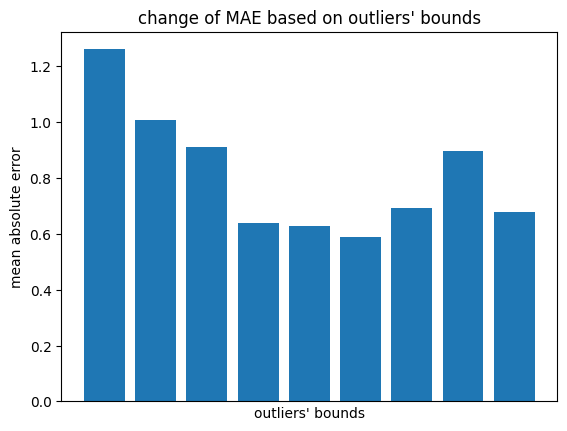

In [573]:
# Plot the array as columns

plt.bar(np.arange(crossval_score.shape[0]), np.mean(crossval_score, axis=(1, 2, 3)), width=0.8)
# for i, bound in enumerate(outliers_bounds):
#     plt.text(i, -0.01, str(bound), ha="center", va="top")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.xlabel("outliers' bounds")
plt.ylabel("mean absolute error")
plt.title("change of MAE based on outliers' bounds")
plt.xticks()
plt.show()

In [581]:

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # evaluate the best result from crossvalidation on real data
    min_crossval_score_id = getIndexWithMinValue(crossval_score)
    opt_bounds = outliers_bounds[min_crossval_score_id[0]]
    opt_n_estimators = n_estimators[min_crossval_score_id[1]]
    opt_concat_wavelength = concat_wavelengths[min_crossval_score_id[2]]
    opt_transform_facial = transform_facials[min_crossval_score_id[3]]

    X_modified, y_modified = X_train.copy(), y_train.copy()
    outliers = findOutliersUsingIQR(X_modified, bounds=opt_bounds)
    X_modified, y_modified = removeOutliers(X_modified, y_modified, outliers)
    if opt_concat_wavelength != None:
        X_modified = reduceEEG(X_modified, concat_wavelengths=opt_concat_wavelength)
        # X_test = reduceEEG(X_test, concat_wavelengths=opt_concat_wavelength)
    if opt_transform_facial:
        X_modified = transformFacialVideo(X_modified)
        # X_test = transformFacialVideo(X_test)

    # model = RandomForestRegressor(random_state=42, n_estimators=opt_n_estimators)
    model = DecisionTreeRegressor(random_state=42, min_impurity_decrease=0.01)
    model.fit(X_modified, y_modified)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

print(f"mean absolute error: {mae}")            # mean absolute error: 0.3
# not the best model apparently, but I could not find a better one

mean absolute error: 0.48654383593625516


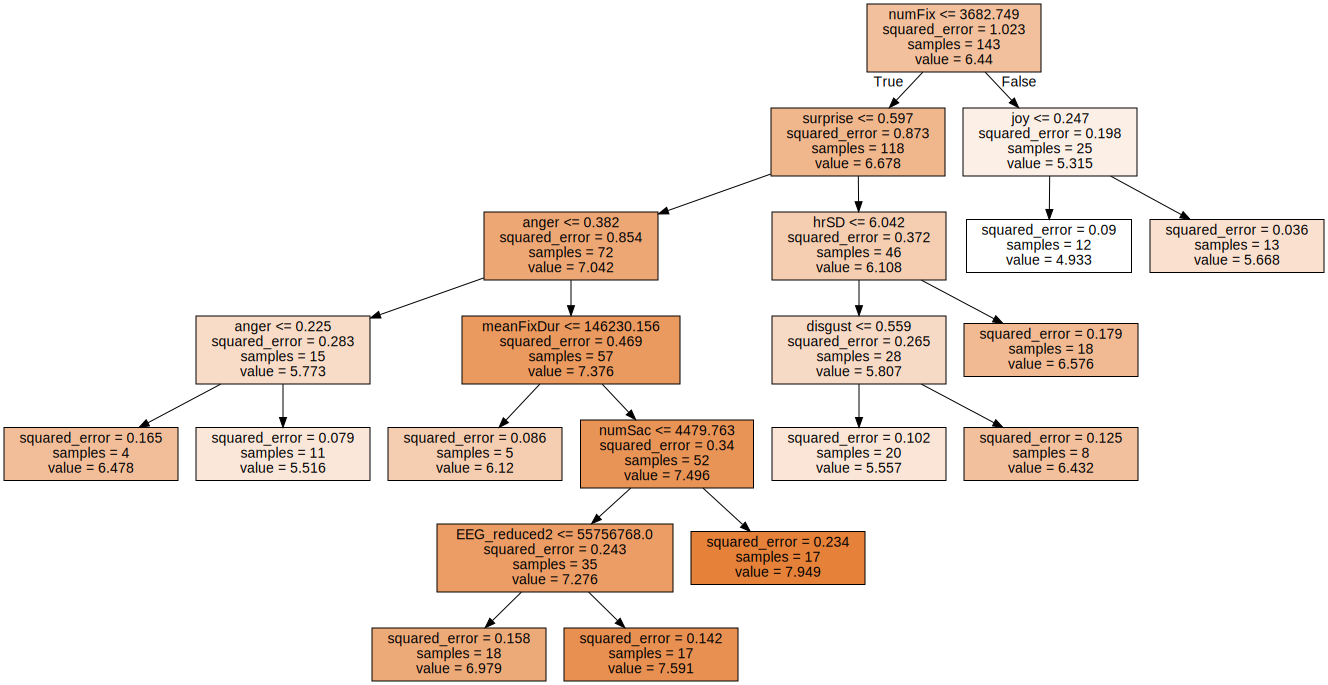

In [582]:
dot_data = export_graphviz(model, feature_names=X_modified.columns, filled=True)
graph = graphviz.Source(dot_data, format="png")
graph.render("regression_tree")
graph